## Importing Libraries

In [1]:
## Importing all required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
import tensorflow as tf

## Loading Data

In [4]:
## Loading data 
train_data = pd.read_csv("train.csv", encoding="iso-8859-1", header=0, index_col=0).dropna(subset=['Word'])
dev_data = pd.read_csv("dev.csv", encoding="iso-8859-1", header=0, index_col=0).dropna(subset=['Word'])
test_data = pd.read_csv("test.csv", encoding="iso-8859-1", header=0, index_col=0).dropna(subset=['Word'])

In [5]:
train_data.head()

,Sentence #,Word,Pos,Tag
0,1,variable,NaN,O
1,1,temperature,NaN,O
2,1,electron,NaN,B-CMT
3,1,paramagnetic,NaN,I-CMT
4,1,resonance,NaN,I-CMT


In [6]:
train_data.shape, dev_data.shape, test_data.shape

((110537, 4), (12745, 4), (13992, 4))

## Constructing Word to Index and Tag to Index Mappings

In [7]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["Pos"].values.tolist(),
                   data["Tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

In [8]:
def char(sentences, char2index):
    char_X = [[[char for char in word[0]] for word in sentence] for sentence in sentences]
    char_X = [[[char2index[char] if char in char2index.keys() else char2index["--UNKNOWN_CHAR--"] for char in word] for word in sentence] for sentence in char_X]
    char_X = [sentence + [[char2index["--PADDING--"]]] * (MAX_SENTENCE - len(sentence)) for sentence in char_X]
    char_X = [[word + [char2index["--PADDING--"]] * (MAX_CHAR - len(word)) for word in sentence] for sentence in char_X]
    
    return np.array(char_X)

In [9]:
def word(sentences, word2index):
    word_X = [[word[0] for word in sentence] for sentence in sentences]
    word_X = [[word2index[word] for word in sentence] for sentence in word_X]
    word_X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in word_X]
    
    return np.array(word_X)

In [10]:
def tag(sentences, tag2index):
    y = [[word[2] for word in sentence] for sentence in sentences]
    y = [[tag2index[tag] for tag in sentence] for sentence in y]
    y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
    TAG_COUNT = len(tag2index)
    y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
    
    return np.array(y)

In [11]:
MAX_CHAR = train_data.Word.apply(len).max()
MAX_SENTENCE = train_data.groupby("Sentence #")["Word"].agg(["count"]).max()[0]
all_chars = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|"
all_words = list(set(train_data["Word"].values).union(dev_data["Word"].values).union(test_data["Word"].values))
all_tags = list(set(train_data["Tag"].values).union(dev_data["Tag"].values).union(test_data["Tag"].values))

char2index = {char: idx + 2 for idx, char in enumerate(all_chars)}
char2index["--UNKNOWN_CHAR--"]=0
char2index["--PADDING--"]=1
index2char = {idx: char for char, idx in char2index.items()}

word2index = {word: idx + 2 for idx, word in enumerate(all_words)}
word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1
index2word = {idx: word for word, idx in word2index.items()}

tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0
index2tag = {idx: word for word, idx in tag2index.items()}

sentences_train = train_data.groupby("Sentence #").apply(to_tuples).tolist()
sentences_dev = dev_data.groupby("Sentence #").apply(to_tuples).tolist()
sentences_test = test_data.groupby("Sentence #").apply(to_tuples).tolist()

char_train = char(sentences_train, char2index)
word_train = word(sentences_train, word2index)
y_train = tag(sentences_train, tag2index)

char_dev = char(sentences_dev, char2index)
word_dev = word(sentences_dev, word2index)
y_dev = tag(sentences_dev, tag2index)
char_test = char(sentences_test, char2index)
word_test = word(sentences_test, word2index)
y_test = tag(sentences_test, tag2index)

In [12]:
word_train.shape, word_test.shape, char_train.shape, char_test.shape, y_train.shape, y_test.shape

((4402, 134),
 (546, 134),
 (4402, 134, 61),
 (546, 134, 61),
 (4402, 134, 18),
 (546, 134, 18))

In [13]:
CHAR_COUNT = len(all_chars) + 2
WORD_COUNT = len(all_words) + 2
TAG_COUNT = len(all_tags) + 1
CHAR_EMBEDDING = 25
WORD_EMBEDDING = 50
FILTERS_NUMBER = 30
WINDOW_SIZE = 3
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 20

In [14]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib import losses, metrics
from keras import layers, optimizers
# Model definition
char_input = layers.Input(shape=(MAX_SENTENCE, MAX_CHAR,), name='char_input')  
# (sample, sentence, words)
char_embedding = layers.TimeDistributed(layers.Embedding(CHAR_COUNT, CHAR_EMBEDDING), name='char_embedding', input_shape=(MAX_SENTENCE, MAX_CHAR))(char_input)
# (sample, sentence, words, embedding)
char_cnn = layers.TimeDistributed(layers.Conv1D(FILTERS_NUMBER, WINDOW_SIZE, activation='tanh', padding='same'), name='1dconv_on_char')(char_embedding)
# (sample, sentence, words, 30)
char_pooling = layers.TimeDistributed(layers.MaxPool1D(pool_size=int(MAX_CHAR)), name='1dpool_on_char')(char_cnn)
# (sample, sentence, 30)
char = TimeDistributed(layers.Flatten())(char_pooling)

word_input = layers.Input(shape=(MAX_SENTENCE,), name='word_input')

word_embedding = layers.Embedding(WORD_COUNT, WORD_EMBEDDING, input_length=MAX_SENTENCE, name='word_embedding')(word_input)

concatenated = layers.concatenate([word_embedding, char], axis=-1)

model = layers.Dropout(rate=0.5)(concatenated)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"), name='dense')(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model([char_input, word_input], output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

2022-03-05 01:28:47.420775: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 134, 61)      0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 134, 61, 25)  2375        char_input[0][0]                 
__________________________________________________________________________________________________
1dconv_on_char (TimeDistributed (None, 134, 61, 30)  2280        char_embedding[0][0]             
__________________________________________________________________________________________________
word_input (InputLayer)         (None, 134)          0                                            
____________________________________________________________________________________________

In [15]:
history = ner_model.fit([char_train, word_train], y_train, 
                        batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, 
                        validation_data=([char_dev, word_dev], y_dev), 
                        verbose=2)

/Users/DELL/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4402 samples, validate on 511 samples
Epoch 1/20
 - 168s - loss: 2.5850 - crf_accuracy: 0.3858 - val_loss: 0.7904 - val_crf_accuracy: 0.8139
Epoch 2/20
 - 161s - loss: 0.6022 - crf_accuracy: 0.8536 - val_loss: 0.3924 - val_crf_accuracy: 0.9119
Epoch 3/20
 - 161s - loss: 0.3273 - crf_accuracy: 0.9303 - val_loss: 0.2944 - val_crf_accuracy: 0.9391
Epoch 4/20
 - 1043s - loss: 0.2802 - crf_accuracy: 0.9384 - val_loss: 0.2712 - val_crf_accuracy: 0.9401
Epoch 5/20
 - 163s - loss: 0.2633 - crf_accuracy: 0.9399 - val_loss: 0.2602 - val_crf_accuracy: 0.9401
Epoch 6/20
 - 160s - loss: 0.2545 - crf_accuracy: 0.9399 - val_loss: 0.2530 - val_crf_accuracy: 0.9399
Epoch 7/20
 - 159s - loss: 0.2477 - crf_accuracy: 0.9401 - val_loss: 0.2464 - val_crf_accuracy: 0.9403
Epoch 8/20
 - 155s - loss: 0.2403 - crf_accuracy: 0.9408 - val_loss: 0.2386 - val_crf_accuracy: 0.9405
Epoch 9/20
 - 158s - loss: 0.2306 - crf_accuracy: 0.9414 - val_loss: 0.2276 - val_crf_accuracy: 0.9405
Epoch 10/20
 - 574s - los

# History

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'CRF Accuracy'}, xlabel='Epochs', ylabel='CRF Accuracy'>],
       dtype=object))

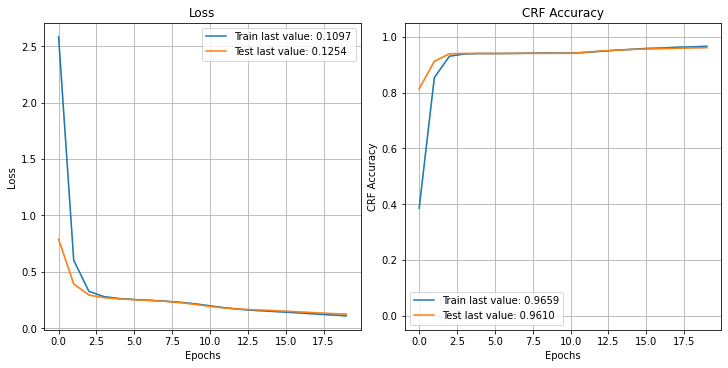

In [16]:
from plot_keras_history import plot_history
plot_history(history.history)

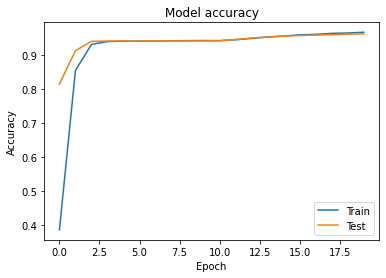

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_accuracy'])
plt.plot(history.history['val_crf_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

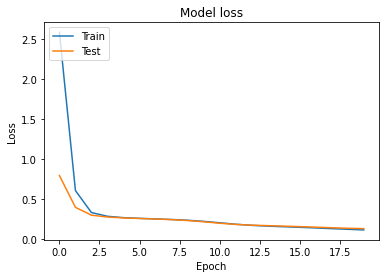

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluation

In [19]:
y_pred = ner_model.predict([char_test, word_test])

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}/".format(accuracy))

Accuracy: 0.9614/


In [20]:
len(y_pred), len(y_test)

(546, 546)

In [21]:
y_test_flatten = [ele for sent in y_test for ele in sent]
y_pred_flatten = [ele for sent in y_pred for ele in sent]

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_true=y_test_flatten, y_pred=y_pred_flatten, labels=None)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59172
           2       0.68      0.65      0.66       437
           3       0.50      0.02      0.04       219
           4       0.00      0.00      0.00       170
           5       0.00      0.00      0.00       135
           7       0.64      0.36      0.46       248
           8       0.00      0.00      0.00        15
           9       0.46      0.59      0.52       771
          10       0.87      0.98      0.92      9605
          11       0.60      0.48      0.53       774
          12       0.61      0.73      0.66       682
          13       0.00      0.00      0.00        98
          14       0.47      0.15      0.23       397
          15       0.00      0.00      0.00       171
          16       0.00      0.00      0.00        75
          17       0.52      0.06      0.11       195

    accuracy                           0.96     73164
   macro avg       0.40   

/Users/DELL/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/DELL/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/DELL/opt/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [23]:
# Check individual tags

from sklearn.metrics import multilabel_confusion_matrix

def tag_conf_matrix(cm, tagid):
    tag_name = index2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

Tag name: I-SPL
[[62111  1448]
 [  207  9398]]
Tag accuracy: 0.977 

Tag name: I-MAT
[[73089     0]
 [   75     0]]
Tag accuracy: 0.999 



## Labeling Individual Sentence

In [24]:
import re, string

sentence = "John is a PhD student in the College of Computing and Informatics."

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")

sentence = re_tok.sub(r" ", sentence).split()

sentence

['John',
 'is',
 'a',
 'PhD',
 'student',
 'in',
 'the',
 'College',
 'of',
 'Computing',
 'and',
 'Informatics']

In [25]:
padded_sentence = sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

In [26]:
padded_word = [[char for char in word] for word in sentence]
padded_word = [[char2index[char] if char in char2index.keys() else char2index["--UNKNOWN_WORD--"] for char in word] for word in padded_word]
padded_word = padded_word + [[char2index["--PADDING--"]]] * (MAX_SENTENCE - len(padded_word))
padded_word = [word + [char2index["--PADDING--"]] * (MAX_CHAR - len(word)) for word in padded_word]

In [27]:
np.array(padded_word).shape

(134, 61)

In [28]:
np.array(padded_sentence).shape

(134,)

In [29]:
pred = ner_model.predict([np.array([padded_word]), np.array([padded_sentence])])
pred = np.argmax(pred, axis=-1)

In [30]:
pred

array([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0]])

In [31]:
retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
print(retval)

John           : O    
is             : O    
a              : O    
PhD            : O    
student        : O    
in             : O    
the            : O    
College        : O    
of             : O    
Computing      : O    
and            : O    
Informatics    : O    

